In [1]:
!pip install -q tensorflow gradio

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image
import zipfile
import os

In [3]:
from google.colab import files
uploaded = files.upload()

Saving E waste data.zip to E waste data.zip


In [4]:
import zipfile
import os

with zipfile.ZipFile('E waste data.zip', 'r') as zip_ref:
    zip_ref.extractall('E waste data')

In [6]:
trainpath = 'E waste data/modified-dataset/train'
testpath = 'E waste data/modified-dataset/test'
validpath = 'E waste data/modified-dataset/val'

IMG_SIZE = 256
BATCH = 32
NUM_CLASSES = 10

# Dataset creation
ds_train = tf.keras.utils.image_dataset_from_directory(trainpath, shuffle=True, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH)
ds_val   = tf.keras.utils.image_dataset_from_directory(validpath, shuffle=True, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH)
ds_test  = tf.keras.utils.image_dataset_from_directory(testpath, shuffle=False, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH)

class_names = ds_train.class_names


Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [7]:
print(len(ds_train.class_names))
class_names = ds_train.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


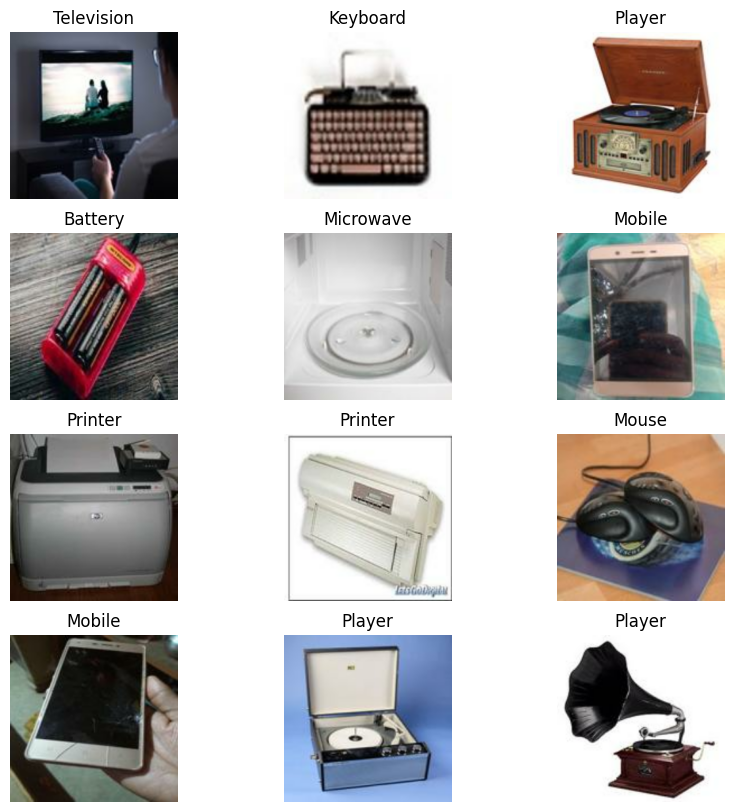

In [8]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in ds_train.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

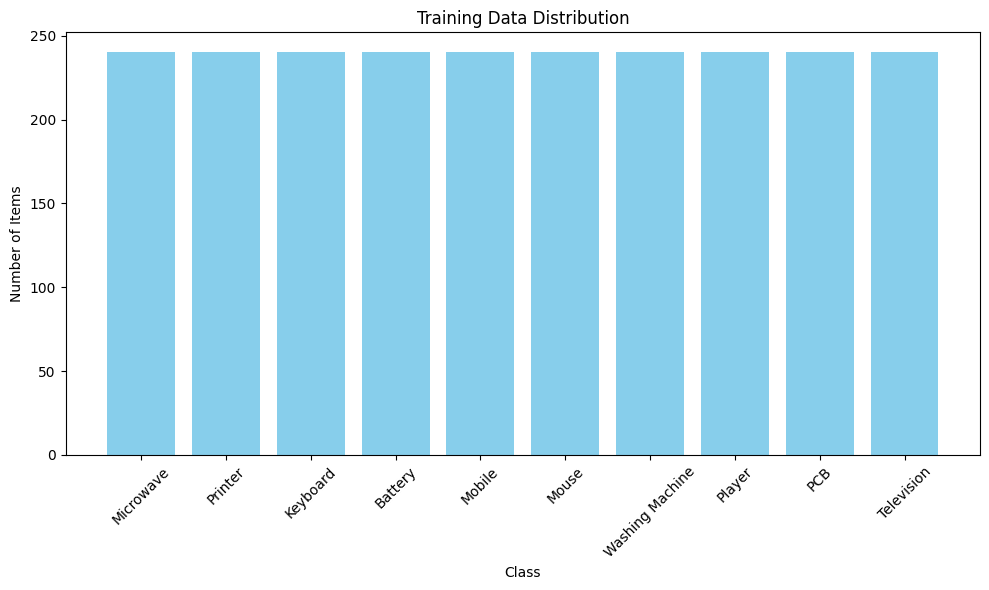

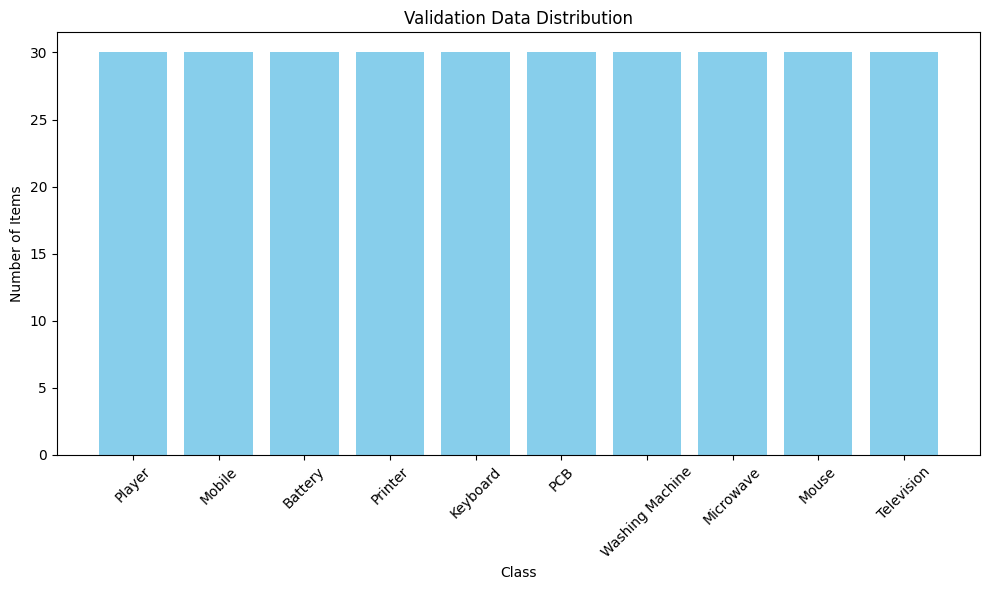

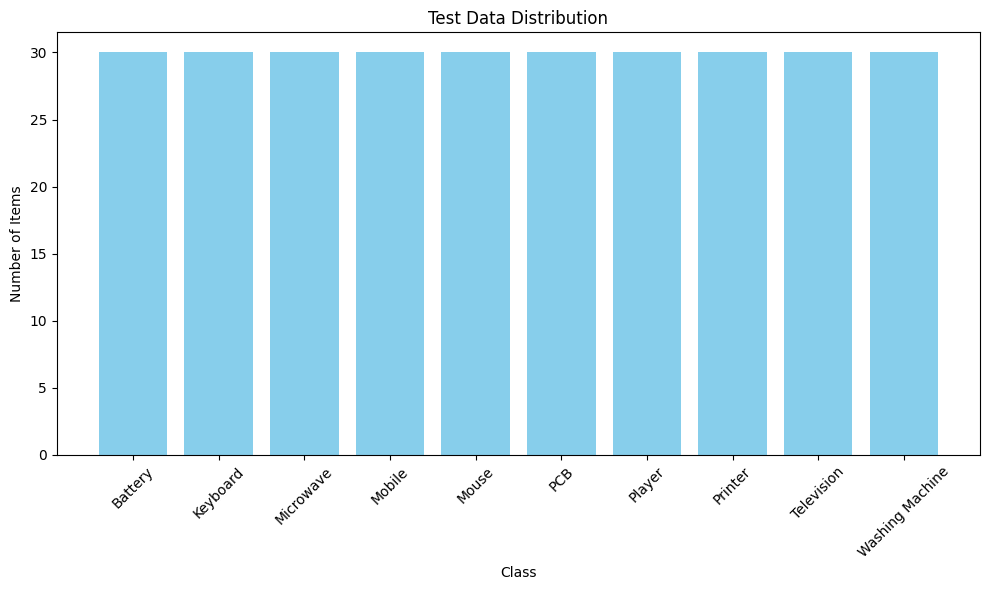

In [9]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """
    class_counts = {}
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Items")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(ds_train, "Training Data Distribution")
plot_class_distribution(ds_val, "Validation Data Distribution")
plot_class_distribution(ds_test, "Test Data Distribution")

In [10]:
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="augmentation")

In [14]:
base_model = MobileNetV3Large(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-80]:
    layer.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = augment(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(inputs, outputs)

In [15]:
# Change loss
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# When loading the dataset, set label_mode='categorical'
ds_train = tf.keras.utils.image_dataset_from_directory(
    trainpath, shuffle=True, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH, label_mode='categorical')
ds_val = tf.keras.utils.image_dataset_from_directory(
    validpath, shuffle=True, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH, label_mode='categorical')
ds_test = tf.keras.utils.image_dataset_from_directory(
    testpath, shuffle=False, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH, label_mode='categorical')

model.summary()
base_model.summary()


Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 8, 8, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         9,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,005,962 (11.47 MB)

 Trainable params: 2,804,498 (10.70 MB)

 Non-trainable params: 201,464 (786.97 KB)

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 128, 128,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 128, 128,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 128, 128,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 128, 128,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 128, 128,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 128,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 129, 129,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 64, 64,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 64, 64,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,794,888 (10.66 MB)

 Non-trainable params: 201,464 (786.97 KB)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)
# Train
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=20,
                    callbacks=[early_stop])


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.2485 - loss: 2.2907 - val_accuracy: 0.6700 - val_loss: 1.3078
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.6817 - loss: 1.2704 - val_accuracy: 0.8533 - val_loss: 0.9226
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.8316 - loss: 0.9738 - val_accuracy: 0.8967 - val_loss: 0.8226
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.8625 - loss: 0.8739 - val_accuracy: 0.9200 - val_loss: 0.7616
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.9270 - loss: 0.7614 - val_accuracy: 0.9300 - val_loss: 0.7282
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9325 - loss: 0.7245 - val_accuracy: 0.9400 - val_loss: 0.7097
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.9500 - loss: 0.7153 - val_accuracy: 0.9467 - val_loss: 0.6902
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9616 - loss: 0.6677 - val_accuracy: 0.9567 - v

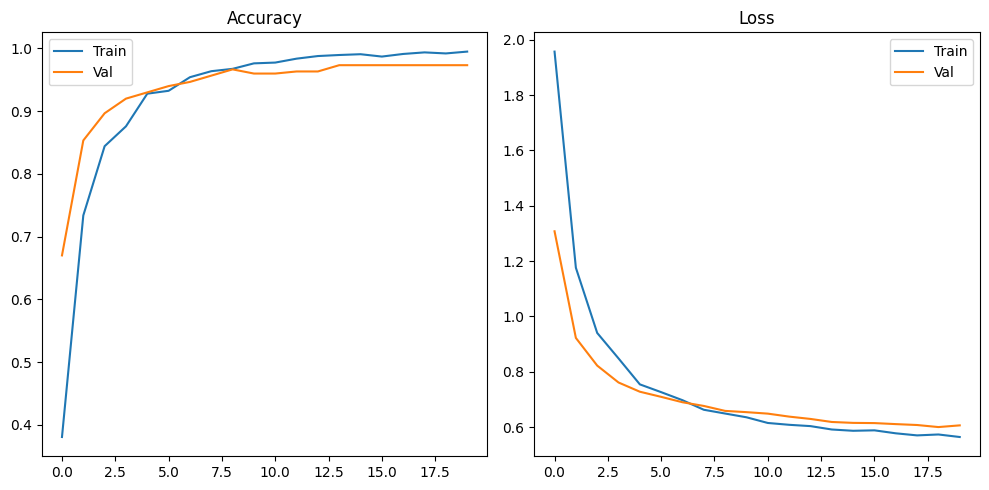

In [18]:
# Plot Accuracy and Loss
acc  = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Evaluate
loss, acc = model.evaluate(ds_test)
print(f"Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9762 - loss: 0.6004
Test Accuracy: 0.9700 | Loss: 0.6081


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
                 precision    recall  f1-score   support

        Battery       1.00      0.97      0.98        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.91      1.00      0.95        30
         Mobile       1.00      1.00      1.00        30
          Mouse       0.97      0.97      0.97        30
            PCB       0.97      0.97      0.97        30
         Player       0.93      0.90      0.92        30
        Printer       0.94      1.00      0.97        30
     Television       1.00      0.90      0.95        30
Washing Machine       1.00      1.00      1.00        30

       accuracy                           0.97       300
      macro avg       0.97      0.97      0.97       300
   weighted avg       0.97      0.97      0.97       300



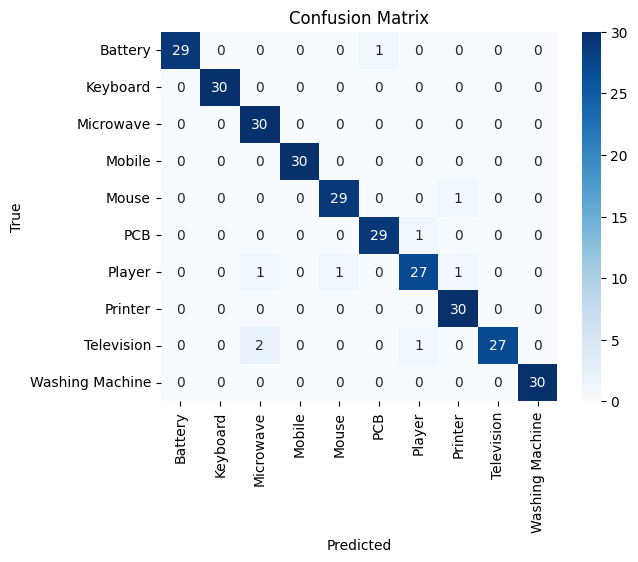

In [21]:
# Confusion Matrix
y_true = np.argmax(np.concatenate([y.numpy() for _, y in ds_test]), axis=1)
y_pred = np.argmax(model.predict(ds_test), axis=1)
cm = confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred, target_names=class_names))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [37]:
import gradio as gr
import numpy as np
from PIL import Image


# 🌱 E-Waste Sorting Instructions Dictionary
sorting_guide = {
    "Battery": [
        "Do NOT dispose of in regular bins – it's hazardous waste.",
        "Store in a cool, dry place away from sunlight.",
        "Drop off at designated battery collection bins or e-waste centers.",
        "Never crush or puncture – risk of fire or chemical leak.",
        "Some electronics shops offer take-back services for used batteries."
    ],
    "Keyboard": [
        "Remove USB or wireless receiver if detachable.",
        "Check for reuse – schools or NGOs may accept donations.",
        "Recycle plastic body as part of general e-waste.",
        "Contains small PCB – valuable for recovery.",
        "Avoid breaking it apart to prevent injury from spring-loaded parts."
    ],
    "Microwave": [
        "Unplug and remove glass tray (recycle separately in glass bin).",
        "Do NOT open the back panel – high-voltage capacitors inside.",
        "Recycle entire unit at e-waste collection point.",
        "Metal parts inside can be recovered at scrapyards.",
        "If working, consider donating to shelters or repair cafés."
    ],
    "Mobile": [
        "Backup data and perform a factory reset before disposal.",
        "Remove SIM and SD card for data protection.",
        "Drop off at certified mobile recycling kiosks or stores.",
        "Contains gold, lithium, cobalt – valuable but toxic if dumped.",
        "Some brands offer cashback or exchange for old mobiles."
    ],
    "Mouse": [
        "Detachable cables should be separated and recycled.",
        "Donate working devices to local organizations or schools.",
        "Plastic and PCB components should go to e-waste bin.",
        "Avoid crushing – contains sharp clicker mechanisms.",
        "Often accepted at tech stores' recycling programs."
    ],
    "PCB": [
        "Contains valuable metals like copper, gold – recycle, don’t trash.",
        "Hazardous materials – should go to certified e-waste handlers.",
        "Avoid direct contact – some coatings can be toxic.",
        "Do not burn – releases brominated toxins.",
        "Can be sold to authorized metal recovery units."
    ],
    "Player": [
        "Remove any batteries before disposal.",
        "Small components like motors and speakers are recyclable.",
        "Plastic casing = e-waste bin.",
        "Working devices may be reused or sold online.",
        "Rare earth magnets inside can be extracted in specialized facilities."
    ],
    "Printer": [
        "Always remove cartridges – dispose via ink recycling.",
        "Recycle cables and plug separately if possible.",
        "Rollers and plastic body go into e-waste stream.",
        "Can contain heavy metals – don’t trash it.",
        "If under warranty, check if brand accepts back."
    ],
    "Television": [
        "CRT TVs = hazardous (lead glass) – handle carefully.",
        "LED/LCDs should be unplugged, and remote separated.",
        "Never smash the screen – risk of mercury dust.",
        "Eligible for free bulk pickup in some cities.",
        "Copper coils inside can be recovered for value."
    ],
    "Washing Machine": [
        "Unplug, drain water fully, and remove power cord if possible.",
        "Outer body (metal/plastic) = e-waste.",
        "Motors and wires are recyclable for metal.",
        "Remove detergent trays – clean and recycle plastic.",
        "Check with municipal collection for heavy appliance pickup."
    ]
}

# 🔍 Classify Image Function
def classify_image(img):
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = preprocess_input(np.array(img, dtype=np.float32))
    pred = model.predict(arr[np.newaxis, ...])
    idx = int(np.argmax(pred))
    class_name = class_names[idx]
    confidence = pred[0][idx]

    # 📦 Fetch Sorting Tips
    instructions = sorting_guide.get(class_name, ["No instructions available."])
    instructions_text = "<br>".join([f"👉 {point}" for point in instructions])


    return f"""
## 🧠 Prediction Result
**Item:** `{class_name}`
**Confidence:** `{confidence:.2f}`

---

## ♻️ Sorting Instructions
{instructions_text}
"""

# 🎨 Interface Using gr.Blocks
with gr.Blocks(css="""
#main-title {font-size: 2.2em; color: #2E8B57; text-align: center;}
.subtext {font-size: 1.1em; color: #555; text-align: center; margin-bottom: 1.5em;}
img {border-radius: 12px;}
""") as demo:

    gr.Markdown('<div id="main-title">📱 Smart E-Waste Classifier</div>')
    gr.Markdown('<div class="subtext">Upload an image to get classification and proper disposal tips based on your e-waste type 🌏</div>')

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="📸 Upload or Snap E-Waste")
            classify_btn = gr.Button("🔍 Classify Item")
        with gr.Column():
            output = gr.Markdown(label="📋 Results")

    classify_btn.click(fn=classify_image, inputs=image_input, outputs=output)

    gr.Markdown("---")

#  Launch It
demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4dbe537322dcf41679.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
